<a href="https://colab.research.google.com/github/chemoinformatics-lecture/lecture-beginner/blob/main/lesson06_scikit-learn/lecture_note_sklearn_colab_%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0_random_forest_fp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 行うこと

- ライブラリーの読み込みとバージョンの確認
- データの読み込みと加工
- トレーニングデータとテストデータの分割 train_test_split
- 学習:  model.fit()
- 結果の確認 model.predict()
- 重要度解析
- その他に検討する項目

# ライブラリーの読み込みとバージョンの確認

In [1]:
#rdkitのインストール
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 457 kB/s 


In [2]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools
print(rdBase.rdkitVersion)

2022.03.5


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

# ファイルのダウンロード

In [6]:
!wget 'http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat'

--2022-10-12 02:03:35--  http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat
Resolving modem.ucsd.edu (modem.ucsd.edu)... 132.239.68.159
Connecting to modem.ucsd.edu (modem.ucsd.edu)|132.239.68.159|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52906 (52K) [text/plain]
Saving to: ‘data_set.dat’

data_set.dat        100%[===================>]  51.67K   199KB/s    in 0.3s    

2022-10-12 02:03:35 (199 KB/s) - ‘data_set.dat’ saved [52906/52906]



In [7]:
# データの読み込み
df = pd.read_csv('data_set.dat', sep='\t', header=None, names = ["smiles", "CAS", "logS"]) 

In [8]:
df

,smiles,CAS,logS
0,O=C(C)N,60-35-5,1.58
1,NNC,60-34-4,1.34
2,O=C(C)O,64-19-7,1.22
3,N1CCCC1,123-75-1,1.15
4,O=C(N)NO,127-07-1,1.12
...,...,...,...
1285,Clc1c(c2c(ccc(Cl)c2Cl)Cl)c(ccc1Cl)Cl,38411-22-2,-8.65
1286,c1c2c(ccc3c2cccc3)cc2c1ccc1ccccc12,53-70-3,-8.66
1287,c1c2c3cccc4ccc5ccc6c(c2c(cc6)cc1)c5c43,191-24-2,-9.03
1288,Clc1c(Cl)c(c2cc(c(c(Cl)c2Cl)Cl)Cl)c(c(c1Cl)Cl)Cl,40186-72-9,-10.26


In [9]:
PandasTools.AddMoleculeColumnToFrame(df, "smiles")

,smiles,CAS,logS,ROMol
0,O=C(C)N,60-35-5,1.58,
1,NNC,60-34-4,1.34,
2,O=C(C)O,64-19-7,1.22,

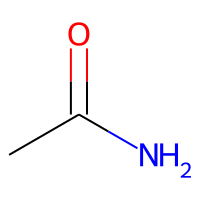
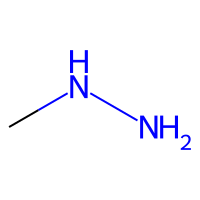
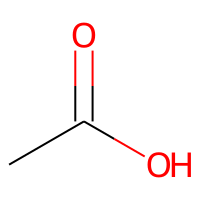

In [11]:
df.head(3)

# データの確認と加工 (finger printの作成)

In [14]:
# 欠損状態があるかを確認
df.isnull().sum()

smiles    0
CAS       0
logS      0
ROMol     1
dtype: int64

In [16]:
# 欠損状態になっているデータの行を削除する。
df = df.dropna(subset=['ROMol'], axis=0)
# 欠損がなくなっているかを確認
df.isnull().sum()

smiles    0
CAS       0
logS      0
ROMol     0
dtype: int64

In [17]:
# indexを振り直し
df = df.reset_index()

In [19]:
import numpy as np

fingerprints = []
safe = []
for mol_idx, mol in enumerate(df["ROMol"]):
    try:
        fingerprint = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
        fingerprints.append(fingerprint)
        safe.append(mol_idx)
        
    except:
        print("Error", mol_idx)
        continue
fingerprints = np.array(fingerprints)
print(fingerprints.shape)
df_fp = pd.DataFrame(fingerprints)

(1289, 2048)


,index,smiles,CAS,logS,ROMol,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,O=C(C)N,60-35-5,1.58,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,NNC,60-34-4,1.34,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,O=C(C)O,64-19-7,1.22,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

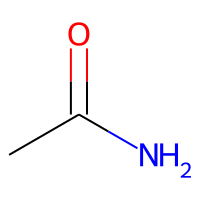
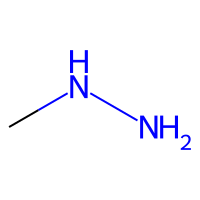
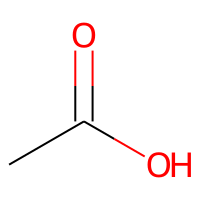

In [33]:
df_comb = pd.merge(df, df_fp, left_index=True, right_index=True)
df_comb.head(3)

# トレーニングデータとテストデータの分割

In [34]:
X = df_fp

In [35]:
y = df['logS']

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 10)


In [38]:
X_train = X_train.sort_index()
X_train

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
X_test = X_test.sort_index()
X_test

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
y_train = y_train.sort_index()
y_train

0        1.58
1        1.34
2        1.22
3        1.15
4        1.12
        ...  
1283    -8.60
1284    -8.65
1285    -8.66
1286    -9.03
1287   -10.26
Name: logS, Length: 1160, dtype: float64

In [41]:
y_test = y_test.sort_index()
y_test

7        1.10
11       1.07
31       0.57
35       0.48
43       0.32
        ...  
1249    -5.46
1253    -5.80
1254    -5.89
1256    -6.02
1288   -10.41
Name: logS, Length: 129, dtype: float64

# 学習

In [42]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth = 100, n_estimators = 500, n_jobs = -1, random_state = 100)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, n_estimators=500, n_jobs=-1,
                      random_state=100)

In [43]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
score = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(score)
print(f'rmse: {rmse:.4f}')
score2 = r2_score(y_test, y_pred)
print("R2", score2)
y_predtrain = model.predict(X_train)

rmse: 0.9585
R2 0.794712452048112


In [44]:
y_predtrain = y_predtrain.reshape(-1, 1)
y_predtrain = pd.DataFrame(y_predtrain)
y_predtrain

,0
0,0.98820
1,0.55908
2,0.73486
3,0.77757
4,0.76450
...,...
1155,-7.61320
1156,-7.35270
1157,-7.26858
1158,-8.40412


# 結果の確認

In [ ]:
from sklearn.model_selection import cross_val_score
cross_validation = cross_val_score(model, X_train, y_train, scoring ='neg_mean_squared_error', cv = 10)

In [ ]:
cross_validation = cross_validation * -1
cross_validation

array([2.96691435, 1.07286643, 0.63975377, 0.85514998, 0.98586628,
       1.78400882, 4.20365632, 0.90112125, 0.63356881, 2.49829557])

In [ ]:
rmse = np.mean(np.sqrt(cross_validation))
print('RMSE_CV')
print(rmse)

RMSE_CV
1.2187557369260615


In [ ]:
y_test

7        1.10
11       1.07
31       0.57
35       0.48
43       0.32
        ...  
1249    -5.46
1253    -5.80
1254    -5.89
1256    -6.02
1288   -10.41
Name: logS, Length: 129, dtype: float64

In [ ]:
y_pred = pd.Series(y_pred)
y_test.reset_index(inplace=True, drop=True)
rf_plot = pd.concat([y_test, y_pred], axis = 1)
rf_plot.columns = ['y_test', 'y_pred']
rf_plot

,y_test,y_pred
0,1.10,-0.789400
1,1.07,0.653910
2,0.57,-0.366320
3,0.48,-0.851920
4,0.32,-0.252900
...,...,...
124,-5.46,-4.002275
125,-5.80,-4.395840
126,-5.89,-5.267340
127,-6.02,-6.063240


In [ ]:
y_train.reset_index(inplace=True, drop=True)
rf_plot2 = pd.concat([y_train, y_predtrain], axis = 1)
rf_plot2.columns = ['y_train', 'pred']
rf_plot2

,y_train,pred
0,1.58,0.98820
1,1.34,0.55908
2,1.22,0.73486
3,1.15,0.77757
4,1.12,0.76450
...,...,...
1155,-8.60,-7.61320
1156,-8.65,-7.35270
1157,-8.66,-7.26858
1158,-9.03,-8.40412


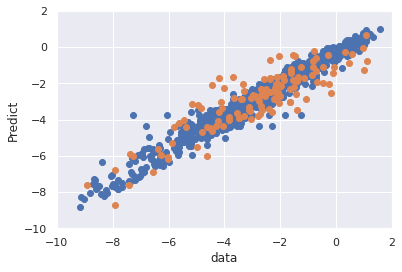

In [ ]:
plt.figure()

x1 = rf_plot2.y_train.astype(float)
y1 = rf_plot2.pred.astype(float)

plt.scatter(x1, y1)

plt.xlim(-10, 2)
plt.ylim(-10, 2)

plt.xlabel('data')
plt.ylabel('Predict')

x2 = rf_plot.y_test.astype(float)
y2 = rf_plot.y_pred.astype(float)

plt.scatter(x2, y2)

plt.show()

# 重要度解析

,feature,feature_importance
561,561,1.493933e-01
1087,1087,6.362906e-02
807,807,4.151840e-02
1380,1380,3.856461e-02
1143,1143,3.366034e-02
...,...,...
1806,1806,2.521278e-08
1559,1559,1.128242e-08
765,765,9.253885e-09
369,369,5.562046e-09


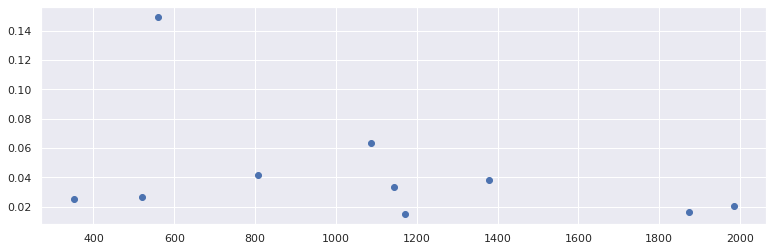

In [ ]:
plt.rcParams["figure.figsize"] = [13,4]
fi_rf = model.feature_importances_  
features_rf = pd.DataFrame({'feature': list(X_train.columns),
                            'feature_importance': fi_rf[:]}).sort_values('feature_importance', ascending = False)
features_rf = features_rf[features_rf['feature_importance'] != 0]
plt.scatter(features_rf.iloc[:10, :].feature, features_rf.iloc[:10, :].feature_importance);
features_rf

# 学習結果から考えることや検討項目など

1. 化合物の表現方法として、フィンガープリント以外にもさまざまな「化学構造記述子」がある。

2. 機械学習手法として、ランダムフォレスト以外にも色々な手法がある。

3. パラメータ調節方法として、グリッドサーチやベイズ最適化などの方法がある。

4. 機械学習で注意すべき点として「過学習」という現象があり、それを防ぐための方法論として「交差検定」などがある。検定方法にも複数種類がある。

5. 外れ値の検証などを行いモデルの精度を高める。

6. 重要だった指標の可視化などを行い解釈性を高める。